In [7]:
import os, sys
import pandas as pd
import numpy as np
import datetime as dt
from pprint import pprint
import csv
import itertools as it
from prettytable import PrettyTable
import matplotlib.pylab as plt
import seaborn as sns
import portion as P
from collections import namedtuple
import math

pdir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # for jupyter-notebook
sys.path.insert(1, pdir)
from myutils import *

%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度
# plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

In [8]:
from collections import namedtuple

### Read Coefficients
coef_ul = pd.read_pickle('./coef_ul.pkl')
coef_dl = pd.read_pickle('./coef_dl.pkl')

### Example
radio1 = {'LTE_HO': None, 'NR_HO': 1, 'RLF': None, 'NR_Setup': None}
radio2 = {'LTE_HO': None, 'NR_HO': None, 'RLF': 3, 'NR_Setup': None}

### Function
def evaluate_plr(radio1, radio2, predict_time=5, spr=5000, show_fig=False):
    
    def heaviside(x, left, right):
    
        if x < left:
            return 0
        elif x > right:
            return 0
        else:
            return 1

    def poly_approx(x_list, type, center=0, mode='ul'):
        
        if center == None:
            p = np.poly1d(0)
            return p(x_list)
        
        if mode == 'ul':
            _coef = list(coef_ul.loc[type])
        else: # mode == 'dl'
            _coef = list(coef_dl.loc[type])
            
        x_list = [x - center for x in x_list]
        lower_bd = _coef[0]
        upper_bd = _coef[1]
        coef = _coef[2:]
        p = np.poly1d(coef)
        
        return np.clip(p(x_list)*np.vectorize(heaviside)(x_list, lower_bd, upper_bd), a_min=0, a_max=100)
    
    OP = namedtuple('Output', 'ul, dl', defaults=(None, None))
    
    eval_plr = []
    
    x = [s/spr for s in list(range(1, predict_time * spr + 1))]
    for mode in ['ul', 'dl']:
        Y1 = []
        Y2 = []
        for tag in ['LTE_HO', 'NR_HO', 'RLF', 'NR_Setup']:
            y1 = poly_approx(x, 'NR_HO', center=radio1[tag], mode=mode)
            y2 = poly_approx(x, 'RLF', center=radio2[tag], mode=mode)
            Y1.append(y1)
            Y2.append(y2)
        y1 = [s1+s2+s3+s4 if s1+s2+s3+s4 <= 100 else 100 for (s1, s2, s3, s4) in zip(Y1[0],Y1[1],Y1[2],Y1[3])]
        y2 = [s1+s2+s3+s4 if s1+s2+s3+s4 <= 100 else 100 for (s1, s2, s3, s4) in zip(Y2[0],Y2[1],Y2[2],Y2[3])]
        y = [s1*s2/100 for (s1, s2) in zip(y1, y2)]
        eval_plr.append(round(np.mean(y), 2))

        if show_fig:
            fig, ax = plt.subplots(figsize=(6, 4))
            ax.plot(x, y, '-', c='tab:orange', lw=0.5)
            ax.fill_between(x, y, color='tab:orange', alpha=0.3)
            ax.set_xlabel('Time (sec)')
            ax.set_ylabel('Evaluated PLR (%)')
            if mode == 'ul':
                ax.set_title('Uplink')
            else:    
                ax.set_title('Downlink')

    return OP(eval_plr[0], eval_plr[1])

0.0
0.05


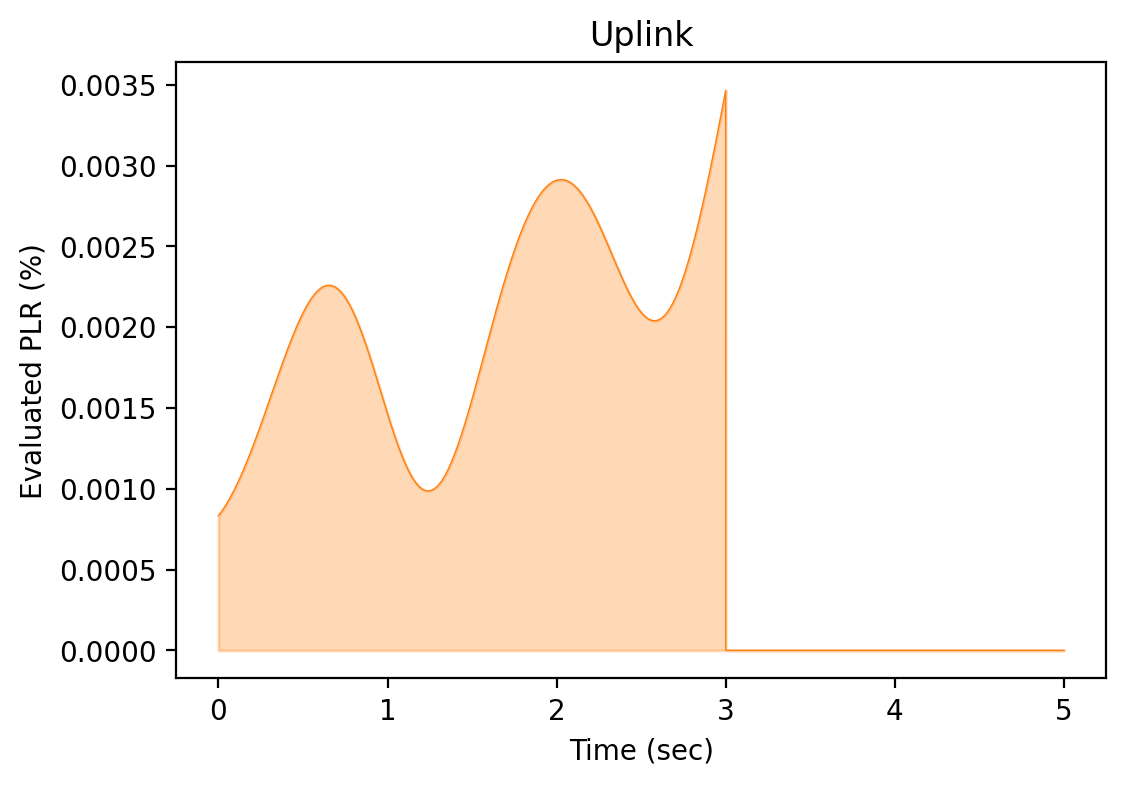

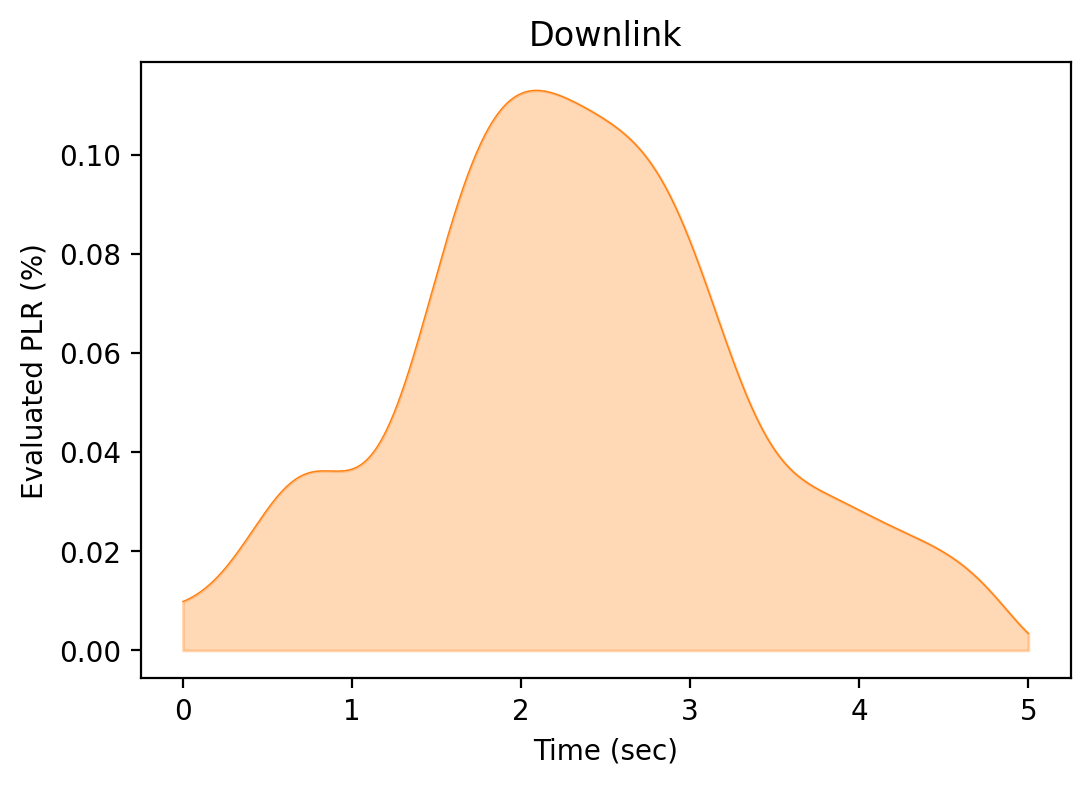

In [9]:
eval_plr = evaluate_plr(radio1, radio2, show_fig=True)
print(eval_plr.ul)
print(eval_plr.dl)